In [167]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import json
import numpy as np
import seaborn as sns
import pandas as pd
import tqdm.notebook as tqdm
from collections import defaultdict

from midynet.utility import display
from functools import partial

from thresholds import collect, susceptiblityFunctions, averageFunctions
from graphinf.utility import seed as gi_seed

import midynet
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import json
import numpy as np

from midynet.utility import display
from functools import partial
from graphinf.utility import seed as gi_seed


def SISSusceptibility(x):
    n = x.sum(0)
    return (np.mean(n**2) - np.mean(n)**2) / np.mean(n)

def SISAverage(x):
    return x.mean()

def GlauberSusceptibility(x):
    x[x == 0] = -1
    m = np.abs(x.mean(0))
    return (np.mean(m**2) - np.mean(m)**2) / (np.mean(m))

def GlauberAverage(x):
    y = x * 1
    y[x == 0] = -1
    X = np.mean(y, 0)
    return np.mean(np.abs(X))

def CowanForwardSusceptibility(x):
    y = x.copy()
    y[x == 0] = -1
    m = y.mean(-1)
    return (np.mean(m**2) - np.mean(np.abs(m))**2)
    
def CowanBackwardSusceptibility(x):
    y = x.copy()
    y = y.mean(0)
    if np.any(y < 0.05):
        y = y[y < 0.05]
    return np.std(y) / np.mean(y)

def CowanSusceptibility(x):
    x = np.array(x)
    print(x[:, 0].mean())
    if x[:,0].mean() == 1:
        return CowanBackwardSusceptibility(x)
    return CowanForwardSusceptibility(x)

def CowanAverage(x):
    return x.mean()


susceptiblityFunctions = {
    "glauber": GlauberSusceptibility,
    "sis": SISSusceptibility,
    "cowan": CowanSusceptibility,
}

averageFunctions = {
    "glauber": GlauberAverage,
    "sis": SISAverage,
    "cowan": CowanAverage,
}


In [168]:
def collect(cfg, seed=None):
    if seed is not None:
        gi_seed(seed)
    suscFunc = susceptiblityFunctions[cfg.data_model.name]
    avgFunc = averageFunctions[cfg.data_model.name]
    graph = midynet.config.GraphFactory.build(cfg.prior)
    dynamics = midynet.config.DataModelFactory.build(cfg.data_model)
    dynamics.set_graph_prior(graph)
    
    dynamics.sample(cfg.data_model.num_active)
    x = np.array(dynamics.get_past_states())
    fig, ax = plt.subplots(figsize=(4,3))
    ax.plot(x.mean(0))
    plt.show()
    return suscFunc(x), avgFunc(x)

def plotThresholdSearch(history, paramName=f"Coupling"):
    fig, ax = plt.subplots(figsize=(4, 3))
    axx = ax.twinx()

    sns.lineplot(history, x="params", y="averages", ax=ax, color="blue")
    sns.lineplot(history, x="params", y="susceptibility",ax=axx, color="red")
    ax.axvline(history["params"][history["susceptibility"].idxmax()], color="grey", linestyle="--")
    ax.set_xlabel(paramName, fontsize=12)
    axx.set_ylabel("Susceptibility", fontsize=12)
    ax.set_ylabel("Order parameter", fontsize=12)

def searchThresholds(
    cfg, 
    paramName, 
    paramMin, 
    paramMax, 
    numPoints=10, 
    delta=1, 
    tol=1e-3, 
    numSamples=10, 
    verbose=1
):
    diff = np.inf

    data = {"params":[], "susceptibility":[], "averages":[]}
    while(diff > tol):
#         susceptibility = []
#         averages = []
        diff = (paramMax - paramMin) / numPoints
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        if verbose > 0:
            print(f"Scaning params {paramScan}")
            print(f"Current diff: {diff}")
        for p in paramScan:
            cfg.data_model[paramName] = p
#             if verbose == 1:
#                 print(p)
            f = partial(collect, cfg)
            seeds = int(time.time()) + np.arange(numSamples).astype("int")
            out = list(map(f, seeds))
            
            s = [ss for ss, aa in out]
            a = [aa for ss, aa in out]
            data["params"].extend([p]*numSamples)
            data["susceptibility"].extend(list(map(lambda x: x[0], out)))
            data["averages"].extend(list(map(lambda x: x[1], out)))
        fig, ax = plt.subplots(figsize=(4, 3))
        sns.lineplot(pd.DataFrame(data), x="params", y="susceptibility", ax=ax)
        plt.show()

        maxIndex = np.argmax(data["susceptibility"])
        paramMin = np.clip(data["params"][maxIndex] - delta * diff, 0, np.inf)
        paramMax = data["params"][maxIndex] + delta * diff
        if verbose > 0:
            print(f"Current history: {data}")
    return pd.DataFrame(data)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return (ret[n - 1:] / n)[::n]

def collectCowan(cfg, seed=None):
    if seed is not None:
        gi_seed(seed)
    graph = midynet.config.GraphFactory.build(cfg.prior)
    dynamics = midynet.config.DataModelFactory.build(cfg.data_model)
    dynamics.set_graph_prior(graph)

    dynamics.sample()
    x = np.array(dynamics.get_past_states())
    return np.mean(x)

def searchCowanThresholds(
    cfg, 
    paramMin, 
    paramMax, *, 
    delta=2, 
    tol=0.01,
    numSamples=10,
    numPoints=10,
    numProcs=4,
    verbose=0,
    parallel=True
):
    diff = np.inf
    history = {"params":[], "susceptibility": [], "averages": []}
    while(diff > tol):
        avgx = []
        susceptibility = []
        paramScan = np.linspace(paramMin, paramMax, numPoints)
        diff = (paramMax - paramMin) / numPoints
        
        if verbose > 0:
            print(f"Scanning params: {paramScan}")
            print(f"Current diff: {diff}")
        for p in paramScan:
            cfg.data_model.nu = p
            f = partial(collectCowan, cfg)
            seeds = int(time.time()) + np.arange(numSamples).astype("int")
            x = [f(s) for s in seeds]
            x = np.array(x)
            if np.any(x < 0.05):
                x = x[x < 0.05]
            s = np.std(x) / np.mean(x)
            if verbose == 1:
                print(p, s, np.mean(x))
            susceptibility.append(s)
            avgx.append(np.mean(x))
        avgx = np.array(avgx)
    
        xm = avgx[:-1]
        xp = avgx[1:]
        
        
        gap = np.abs(avgx[1:] - avgx[:-1]) / diff
        gap = np.append(gap, 0)
        maxGapIndex = np.argmax(gap)
#         maxGapIndex = np.argmax(susceptibility)
        paramMin = paramScan[maxGapIndex] - delta * diff
        paramMax = paramScan[maxGapIndex] + delta * diff
        if verbose == 1:
            ax = plt.gca()
            ax.plot(paramScan, avgx, "ro-")
            axx = ax.twinx()
            axx.plot(paramScan, susceptibility, "bs-")
            ax.axvspan(paramMin, paramMax, color="grey", alpha=0.3)
            plt.show()
        for p, x, g in zip(paramScan, avgx, susceptibility):
            if p in history["susceptibility"]:
                history["susceptibility"][p].append(g)
            else:
                history["susceptibility"][p] = [g]
                
            if p in history["averages"]:
                history["averages"][p].append(x)
            else:
                history["averages"][p] = [x]
        history["thresholds"].append(paramScan[maxGapIndex])
        if verbose > 0:
            print(f"Current history: {history}")
    return history

In [34]:
data = {}

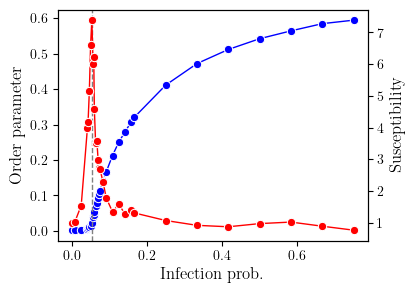

In [46]:
config = midynet.config.ExperimentConfig.reconstruction("susceptiblity", "sis", "nbinom")
config.prior.size = 1000
config.prior.edge_count = 2500
config.prior.heterogeneity = 1

config.data_model.length = 5000
config.data_model.recovery_prob = 0.5
config.data_model.auto_activation_prob = 0.001
config.data_model.num_active = 1



data["sis"] = searchThresholds(config, "infection_prob", 0, 0.75, tol=0.01, numSamples=10, verbose=1)
plotThresholdSearch(data["sis"], paramName="Infection prob.")

Scaning params [1.00000000e-04 5.56444444e-02 1.11188889e-01 1.66733333e-01
 2.22277778e-01 2.77822222e-01 3.33366667e-01 3.88911111e-01
 4.44455556e-01 5.00000000e-01]
Current diff: 0.04999
0.0001


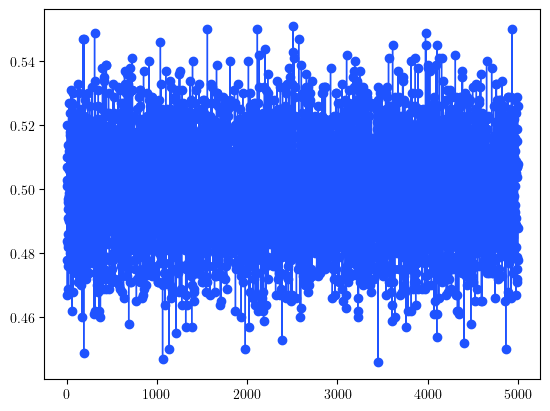

0.0001 [0.014499642138304337]
0.05564444444444445


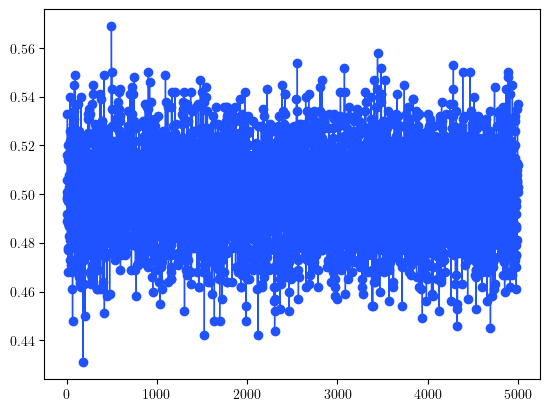

0.05564444444444445 [0.015846590613191717]
0.11118888888888889


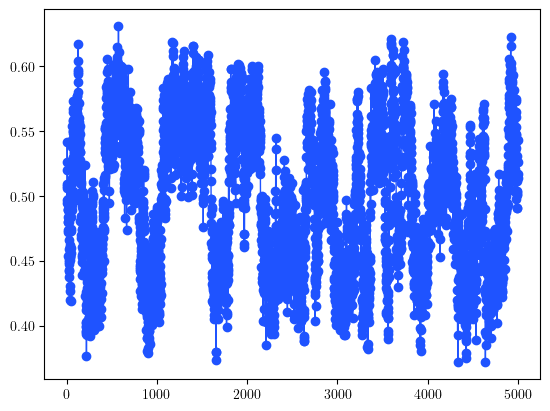

0.11118888888888889 [0.03006161015434936]
0.16673333333333332


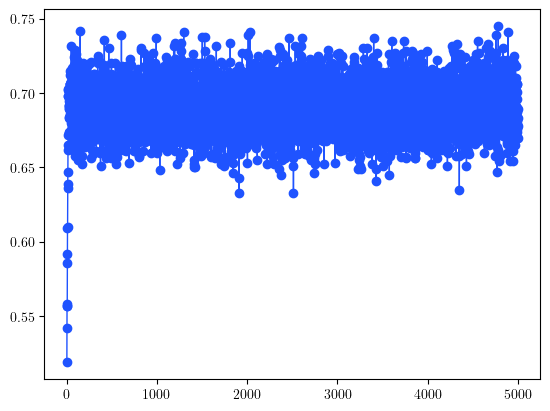

0.16673333333333332 [0.0027826693185387633]
0.22227777777777777


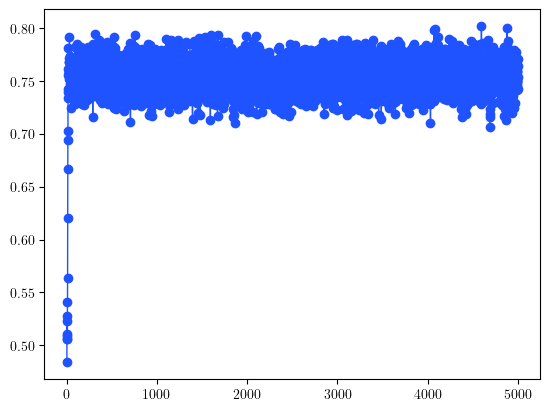

0.22227777777777777 [0.0022079208421476944]
0.2778222222222222


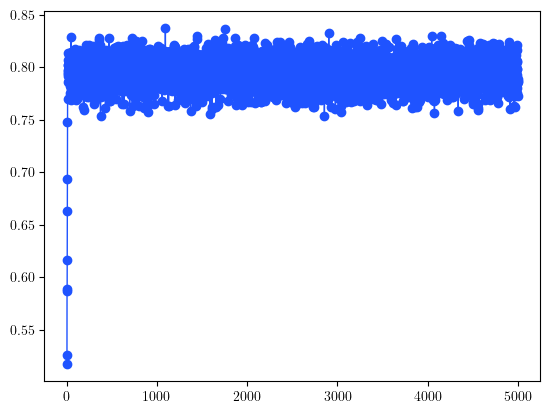

0.2778222222222222 [0.0013772362044656807]
0.33336666666666664


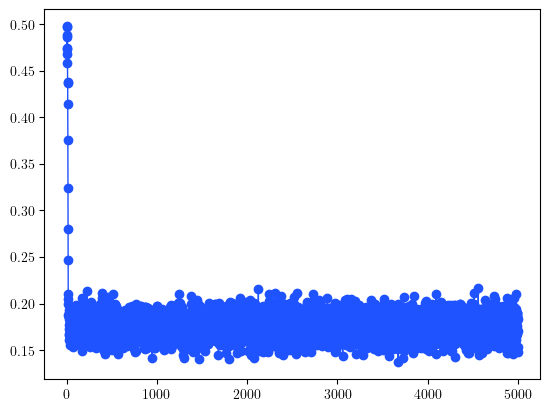

0.33336666666666664 [0.002049262802215792]
0.3889111111111111


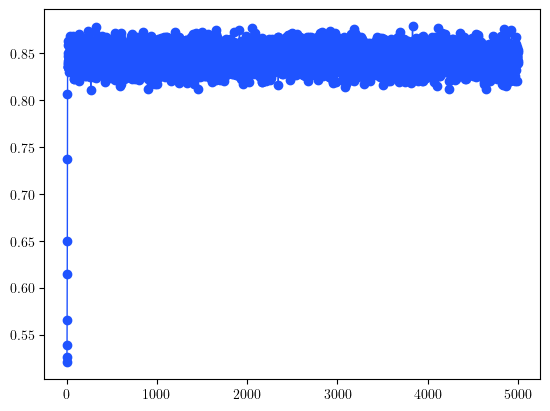

0.3889111111111111 [0.0011930796028199325]
0.44445555555555555


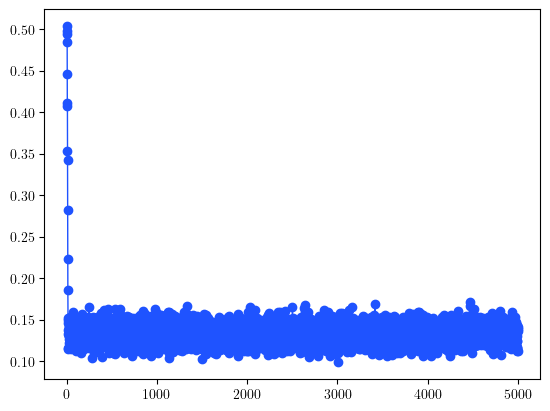

0.44445555555555555 [0.0015117988634531935]
0.5


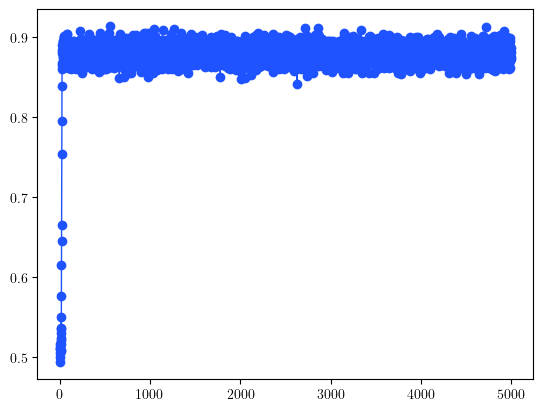

0.5 [0.0029752209588421712]


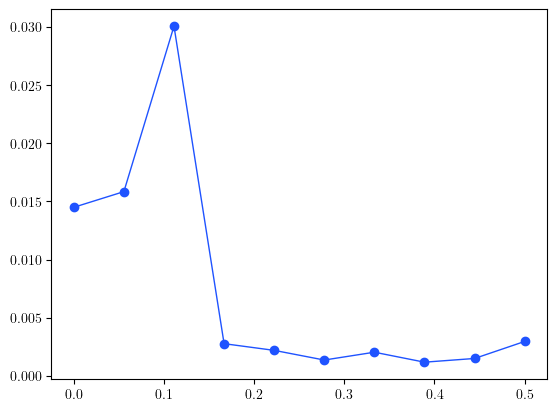

Current history: {'thresholds': [0.11118888888888889], 'susceptibility': {0.0001: [0.014499642138304337], 0.05564444444444445: [0.015846590613191717], 0.11118888888888889: [0.03006161015434936], 0.16673333333333332: [0.0027826693185387633], 0.22227777777777777: [0.0022079208421476944], 0.2778222222222222: [0.0013772362044656807], 0.33336666666666664: [0.002049262802215792], 0.3889111111111111: [0.0011930796028199325], 0.44445555555555555: [0.0015117988634531935], 0.5: [0.0029752209588421712]}, 'averages': {0.0001: [0.024976800000000004], 0.05564444444444445: [0.027417200000000003], 0.11118888888888889: [0.0983224], 0.16673333333333332: [0.38211999999999996], 0.22227777777777777: [0.5082624], 0.2778222222222222: [0.5877727999999999], 0.33336666666666664: [0.64813], 0.3889111111111111: [0.6895816], 0.44445555555555555: [0.7309859999999999], 0.5: [0.7583396]}}
Scaning params [0.06119889 0.07230778 0.08341667 0.09452556 0.10563444 0.11674333
 0.12785222 0.13896111 0.15007    0.16117889]
Cu

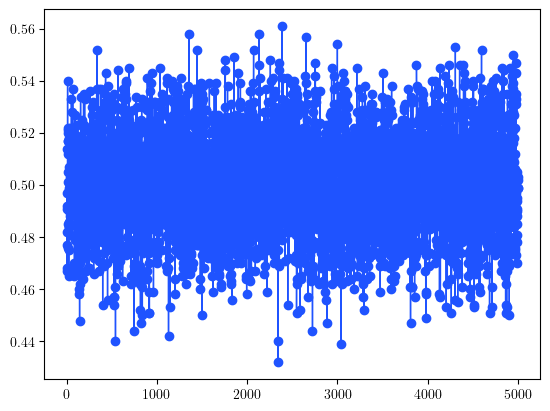

0.06119888888888889 [0.01672429467272908]
0.07230777777777778


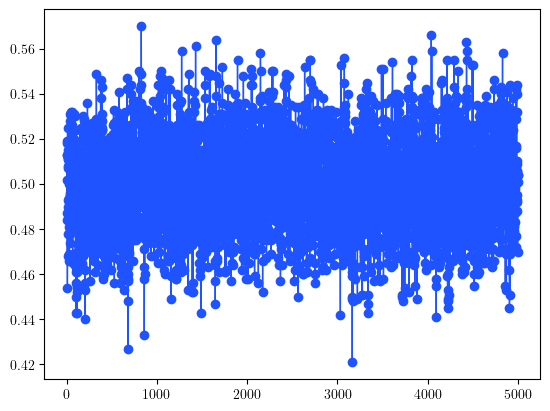

0.07230777777777778 [0.017601376496354116]
0.08341666666666667


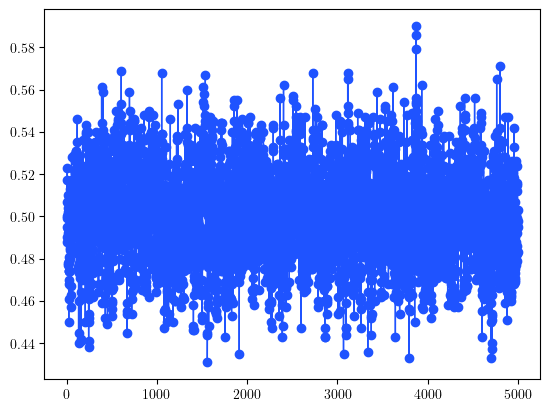

0.08341666666666667 [0.019185986209498653]
0.09452555555555556


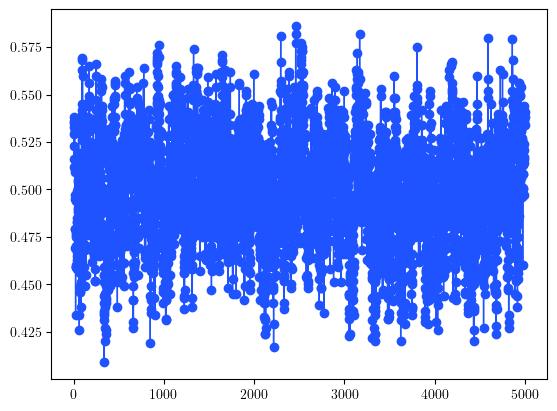

0.09452555555555556 [0.0249587903090322]
0.10563444444444445


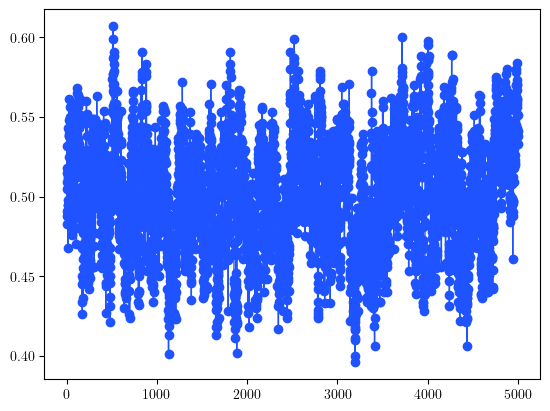

0.10563444444444445 [0.02747069998775912]
0.11674333333333334


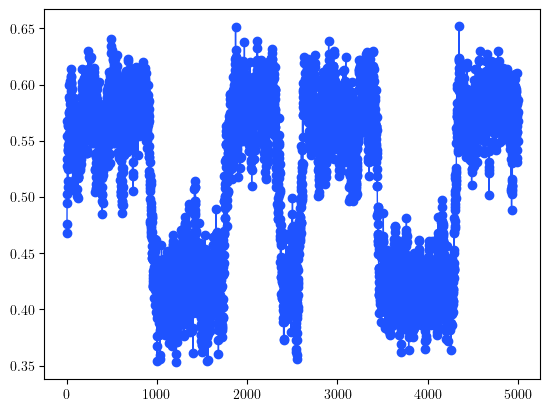

0.11674333333333334 [0.021018526127194292]
0.12785222222222223


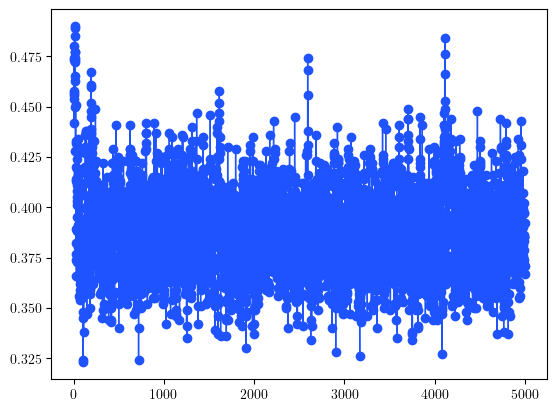

0.12785222222222223 [0.007532668913450212]
0.13896111111111112


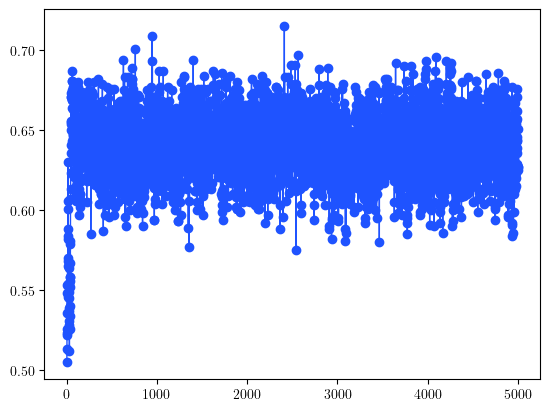

0.13896111111111112 [0.005584242507278695]
0.15007


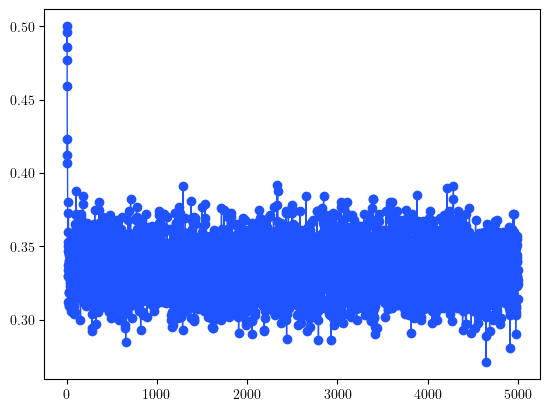

0.15007 [0.0036061930245992945]
0.1611788888888889


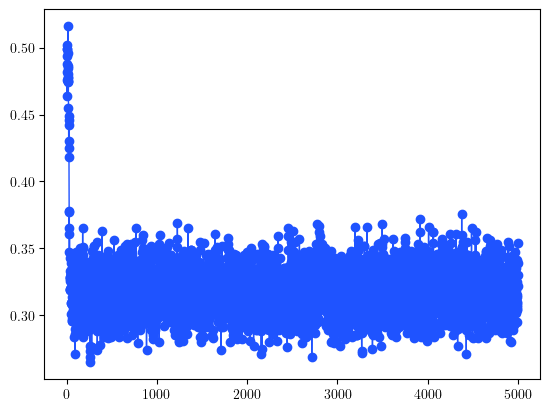

0.1611788888888889 [0.004047403959489847]


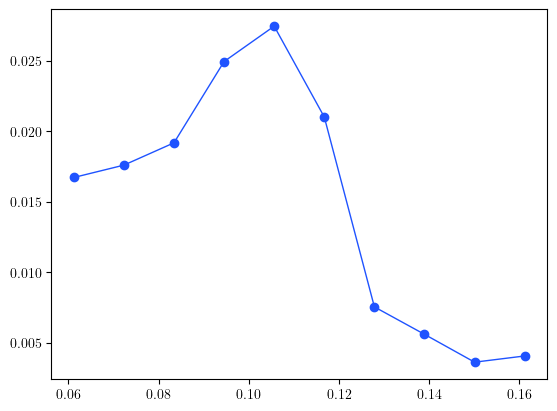

Current history: {'thresholds': [0.11118888888888889, 0.10563444444444445], 'susceptibility': {0.0001: [0.014499642138304337], 0.05564444444444445: [0.015846590613191717], 0.11118888888888889: [0.03006161015434936], 0.16673333333333332: [0.0027826693185387633], 0.22227777777777777: [0.0022079208421476944], 0.2778222222222222: [0.0013772362044656807], 0.33336666666666664: [0.002049262802215792], 0.3889111111111111: [0.0011930796028199325], 0.44445555555555555: [0.0015117988634531935], 0.5: [0.0029752209588421712], 0.06119888888888889: [0.01672429467272908], 0.07230777777777778: [0.017601376496354116], 0.08341666666666667: [0.019185986209498653], 0.09452555555555556: [0.0249587903090322], 0.10563444444444445: [0.02747069998775912], 0.11674333333333334: [0.021018526127194292], 0.12785222222222223: [0.007532668913450212], 0.13896111111111112: [0.005584242507278695], 0.15007: [0.0036061930245992945], 0.1611788888888889: [0.004047403959489847]}, 'averages': {0.0001: [0.024976800000000004], 0

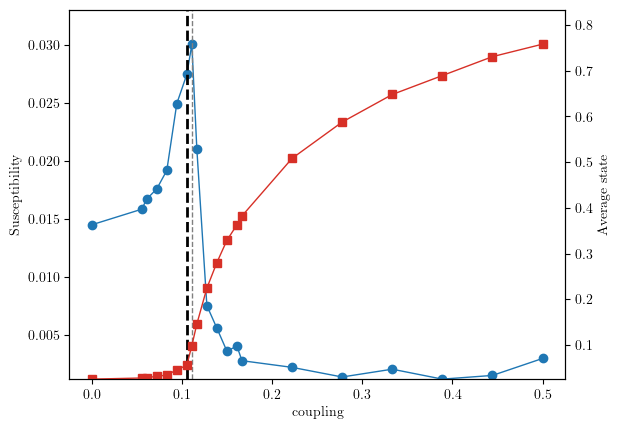

In [7]:
config = midynet.config.ExperimentConfig.reconstruction("susceptiblity", "glauber", "nbinom")
config.prior.size = 1000
config.prior.edge_count = 2500
config.prior.heterogeneity = 1

config.data_model.length = 5000
config.data_model.num_active = -1

histories["glauber"] = searchThresholds(config, "coupling", 0.0001, 0.5, tol=0.01, numSamples=1, verbose=1)
showThresholdSearch(histories["glauber"], f"coupling")

Scaning params [0.         0.08888889 0.17777778 0.26666667 0.35555556 0.44444444
 0.53333333 0.62222222 0.71111111 0.8       ]
Current diff: 0.08


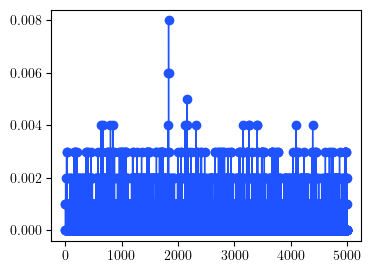

0.001


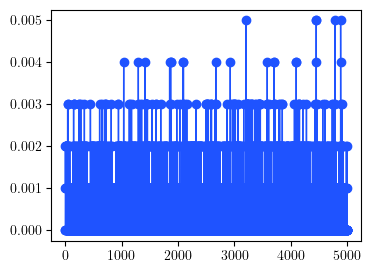

0.001


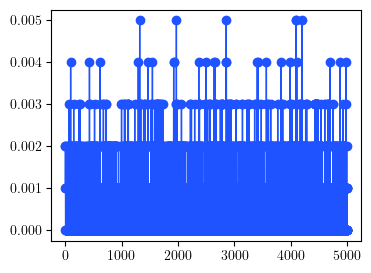

0.001


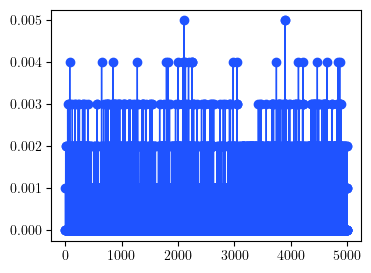

0.001


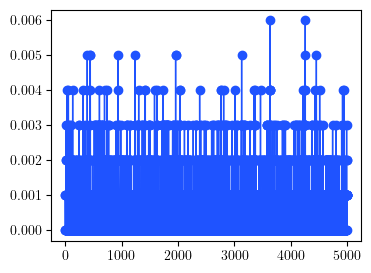

0.001


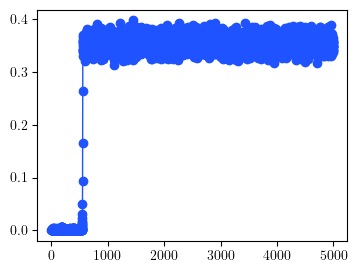

0.001


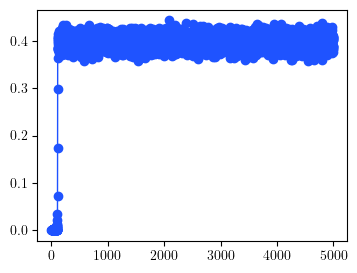

0.001


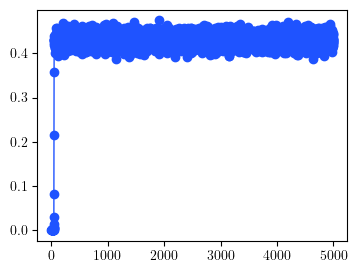

0.001


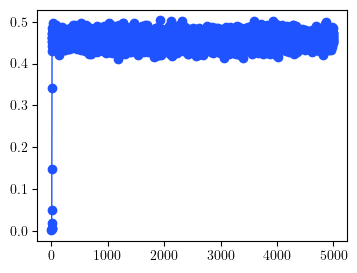

0.001


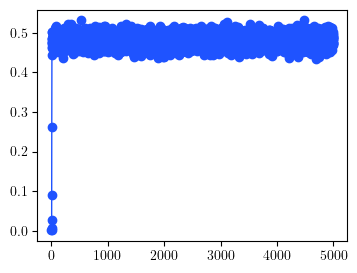

0.001


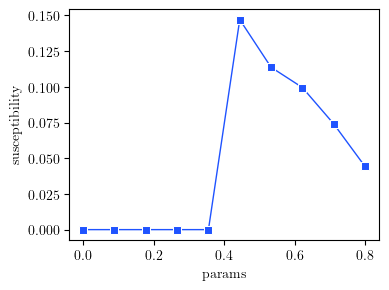

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8], 'susceptibility': [1.6999998402322802e-06, 1.6082560000407753e-06, 1.728825440028281e-06, 1.6598910402843003e-06, 2.067594240040549e-06, 0.14710939056384006, 0.11374441648064001, 0.09954953933055996, 0.07409267024495994, 0.044266264582240006], 'averages': [0.0006498, 0.000664, 0.0006942, 0.0007082, 0.0007488, 0.3155828, 0.3895848, 0.4270804, 0.4573358, 0.481167]}
Scaning params [0.28444444 0.32       0.35555556 0.39111111 0.42666667 0.46222222
 0.49777778 0.53333333 0.56888889 0.60444444]
Current diff: 0.031999999999999994


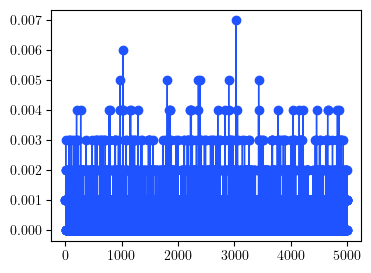

0.001


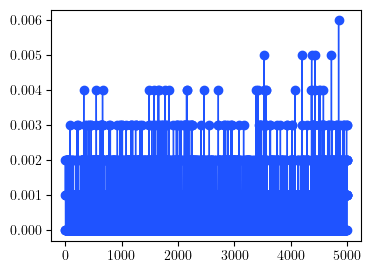

0.001


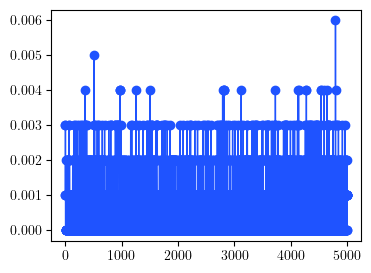

0.001


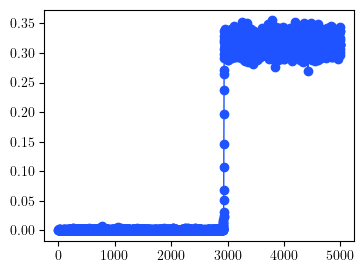

0.001


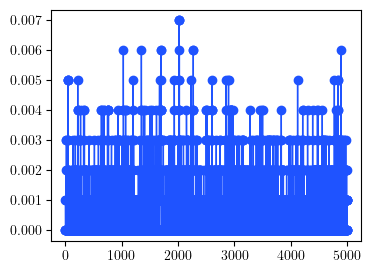

0.001


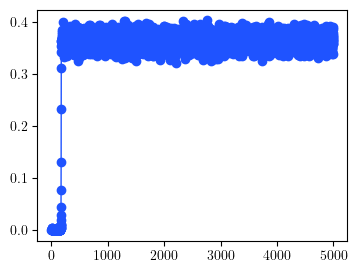

0.001


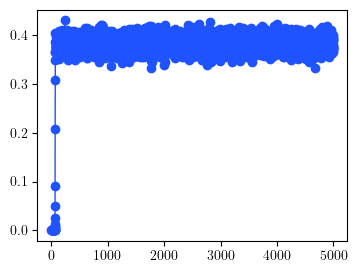

0.001


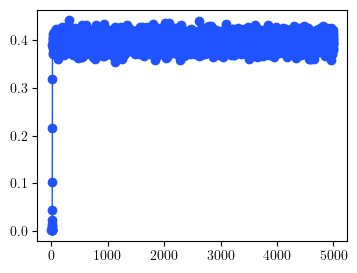

0.001


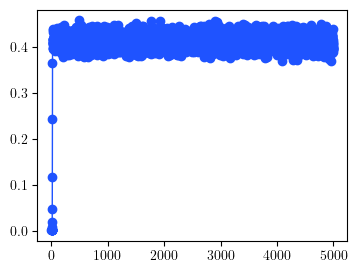

0.001


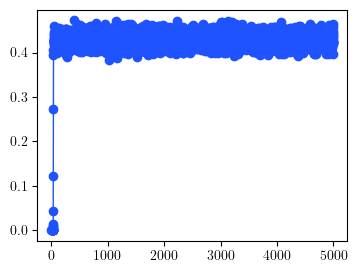

0.001


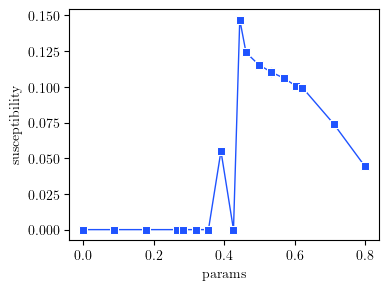

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8, 0.2844444444444445, 0.32000000000000006, 0.3555555555555556, 0.39111111111111113, 0.4266666666666667, 0.46222222222222226, 0.49777777777777776, 0.5333333333333333, 0.5688888888888889, 0.6044444444444445], 'susceptibility': [1.6999998402322802e-06, 1.6082560000407753e-06, 1.728825440028281e-06, 1.6598910402843003e-06, 2.067594240040549e-06, 0.14710939056384006, 0.11374441648064001, 0.09954953933055996, 0.07409267024495994, 0.044266264582240006, 1.8178681600033997e-06, 1.601596000044836e-06, 1.8288318397452485e-06, 0.055012496775040054, 2.0897785600881846e-06, 0.12411273767024006, 0.11560849052400005, 0.10710147551600002, 0.10619725421424003, 0.10059043045999999], 'averages': [0.0006498, 0.000664, 0.0006942, 0.0007082, 0.0007488, 0.3155828, 0.3895848, 0.4270804, 0.4573358, 0.481167, 0.000

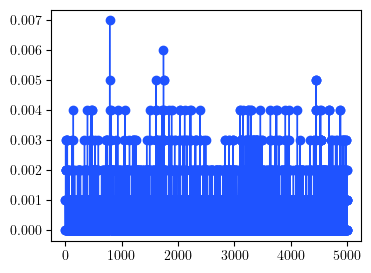

0.001


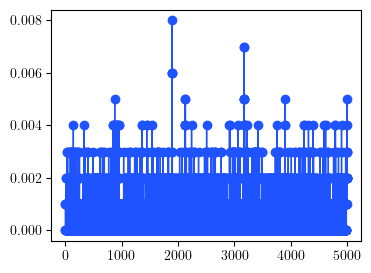

0.001


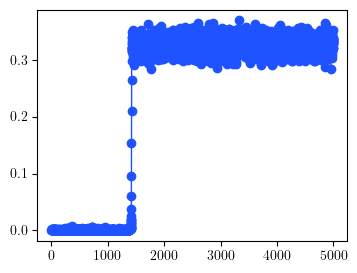

0.001


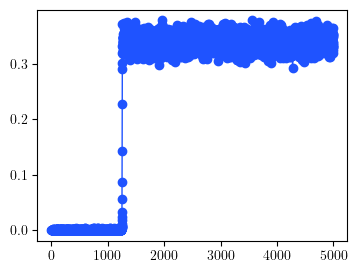

0.001


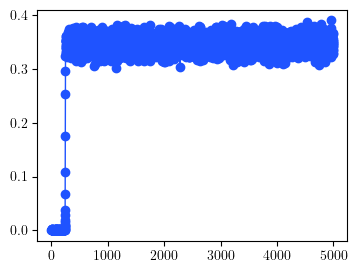

0.001


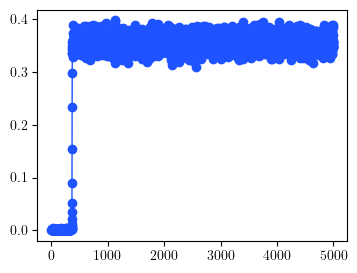

0.001


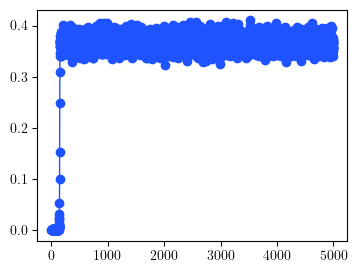

0.001


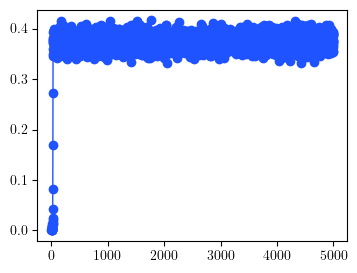

0.001


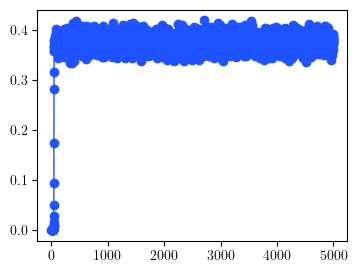

0.001


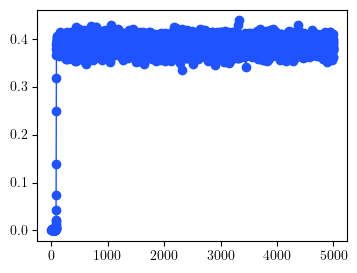

0.001


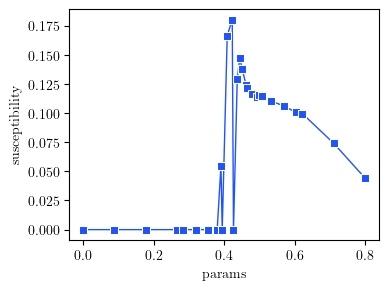

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8, 0.2844444444444445, 0.32000000000000006, 0.3555555555555556, 0.39111111111111113, 0.4266666666666667, 0.46222222222222226, 0.49777777777777776, 0.5333333333333333, 0.5688888888888889, 0.6044444444444445, 0.3804444444444445, 0.3946666666666667, 0.4088888888888889, 0.42311111111111116, 0.43733333333333335, 0.4515555555555556, 0.46577777777777785, 0.48000000000000004, 0.49422222222222223, 0.5084444444444445], 'susceptibility': [1.6999998402322802e-06, 1.6082560000407753e-06, 1.728825440028281e-06, 1.6598910402843003e-06, 2.067594240040549e-06, 0.14710939056384006, 0.11374441648064001, 0.09954953933055996, 0.07409267024495994, 0.044266264582240006, 1.8178681600033997e-06, 1.601596000044836e-06, 1.8288318397452485e-06, 0.055012496775040054, 2.0897785600881846e-06, 0.12411273767024006, 0.1156

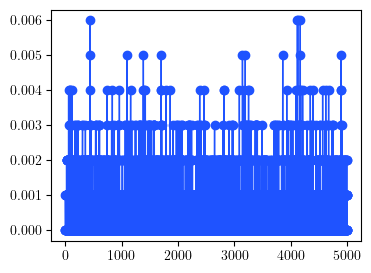

0.001


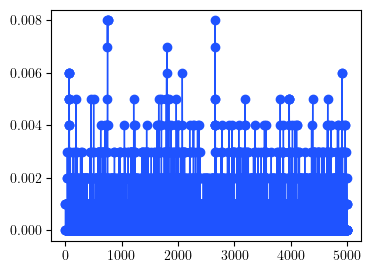

0.001


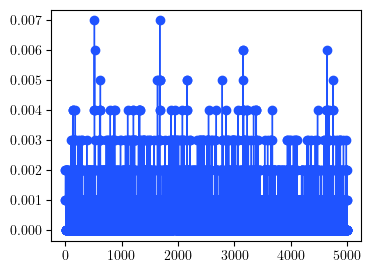

0.001


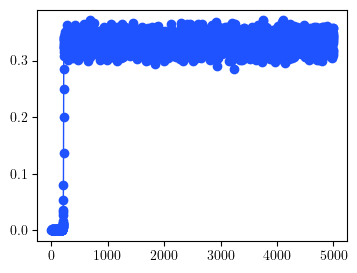

0.001


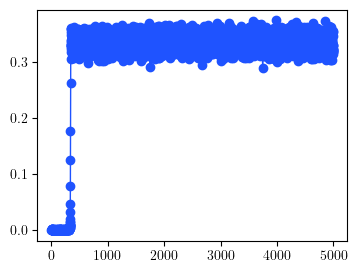

0.001


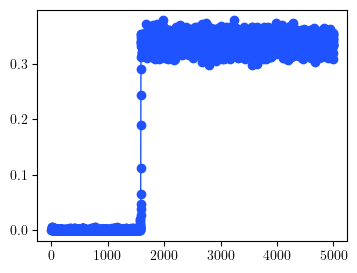

0.001


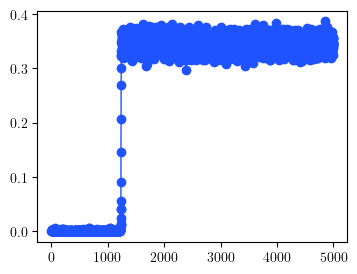

0.001


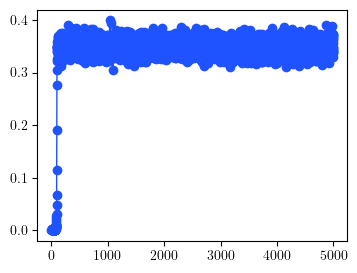

0.001


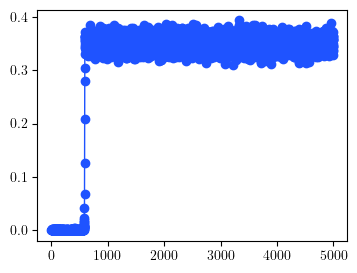

0.001


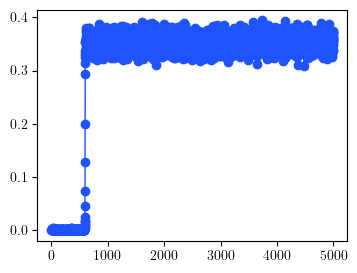

0.001


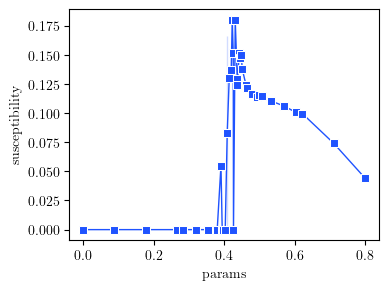

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8, 0.2844444444444445, 0.32000000000000006, 0.3555555555555556, 0.39111111111111113, 0.4266666666666667, 0.46222222222222226, 0.49777777777777776, 0.5333333333333333, 0.5688888888888889, 0.6044444444444445, 0.3804444444444445, 0.3946666666666667, 0.4088888888888889, 0.42311111111111116, 0.43733333333333335, 0.4515555555555556, 0.46577777777777785, 0.48000000000000004, 0.49422222222222223, 0.5084444444444445, 0.39751111111111115, 0.40320000000000006, 0.4088888888888889, 0.4145777777777778, 0.42026666666666673, 0.4259555555555556, 0.4316444444444445, 0.4373333333333334, 0.44302222222222226, 0.44871111111111117], 'susceptibility': [1.6999998402322802e-06, 1.6082560000407753e-06, 1.728825440028281e-06, 1.6598910402843003e-06, 2.067594240040549e-06, 0.14710939056384006, 0.11374441648064001, 0.0

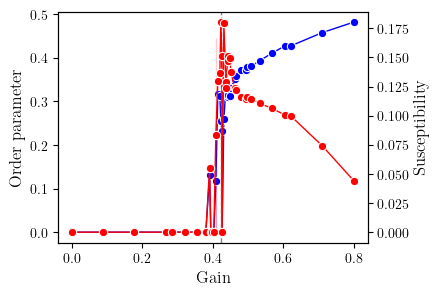

In [170]:
config = midynet.config.ExperimentConfig.reconstruction("susceptiblity", "cowan_forward", "nbinom")

config.prior.size = 1000
config.prior.edge_count = 2500
config.prior.heterogeneity = 1

config.data_model.length = 5000
config.data_model.num_active = 1
config.data_model.a = 8.
config.data_model.eta = 0.5

histories["cowan_forward"] = searchThresholds(config, "nu", 0, 0.8, delta=2, tol=0.01, numSamples=1, numPoints=10, verbose=1)
plotThresholdSearch(histories["cowan_forward"], f"Gain")



In [172]:
3 / 5

0.6

Scaning params [0.         0.08888889 0.17777778 0.26666667 0.35555556 0.44444444
 0.53333333 0.62222222 0.71111111 0.8       ]
Current diff: 0.08


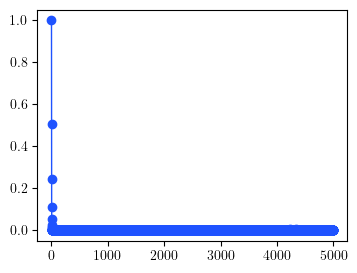

1.0


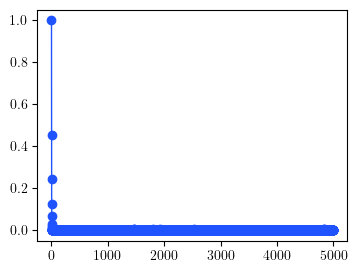

1.0


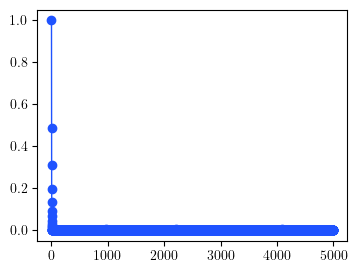

1.0


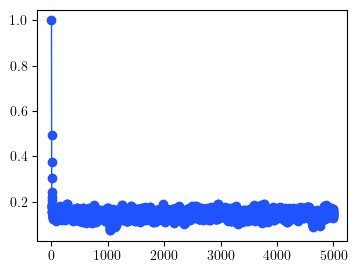

1.0


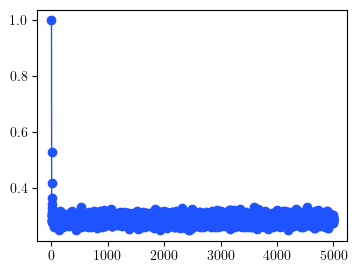

1.0


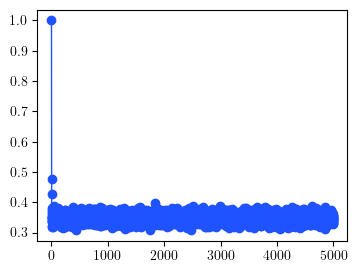

1.0


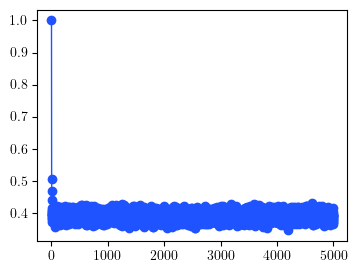

1.0


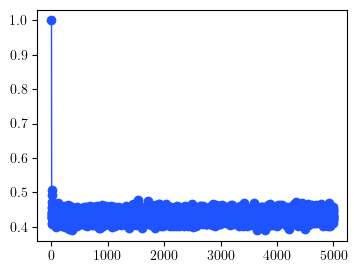

1.0


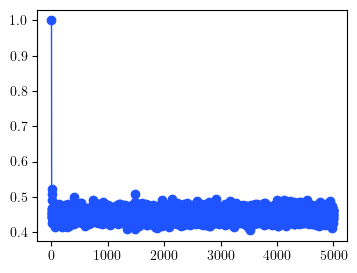

1.0


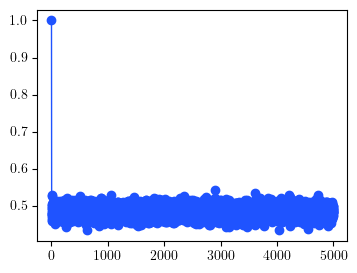

1.0


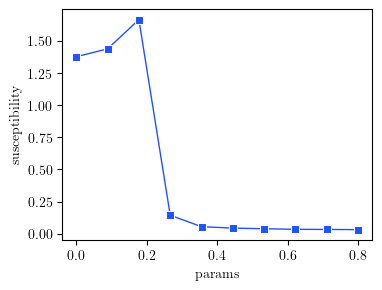

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8], 'susceptibility': [1.376336583088192, 1.4374304264132898, 1.6648349206010837, 0.1437046208359453, 0.05434570903226962, 0.043595903133204605, 0.038200990620026666, 0.03410831899728087, 0.03296486531599741, 0.03156941984050803], 'averages': [0.001077, 0.001092, 0.0011782, 0.1440696, 0.289863, 0.348658, 0.3911356, 0.432257, 0.4505856, 0.4849446]}
Scaning params [0.01777778 0.05333333 0.08888889 0.12444444 0.16       0.19555556
 0.23111111 0.26666667 0.30222222 0.33777778]
Current diff: 0.032


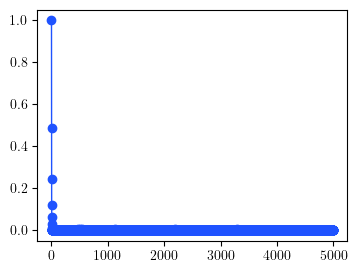

1.0


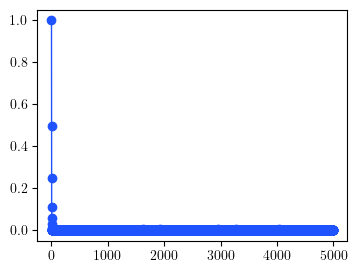

1.0


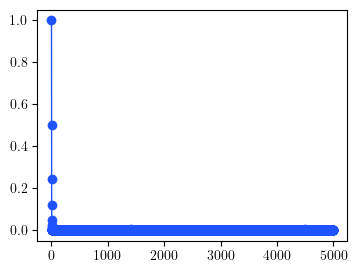

1.0


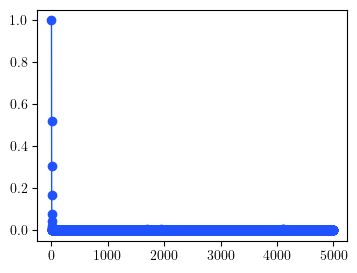

1.0


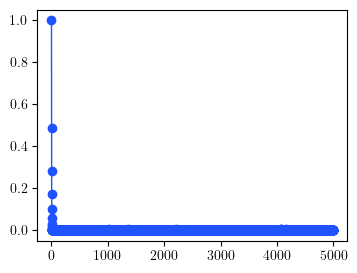

1.0


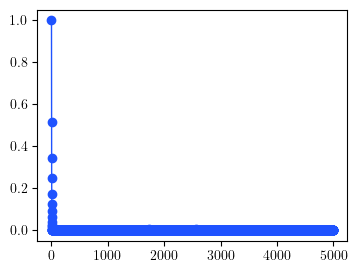

1.0


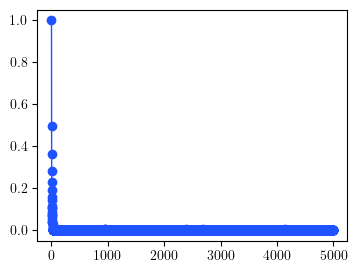

1.0


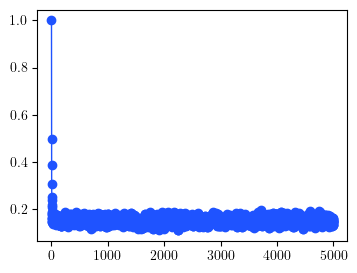

1.0


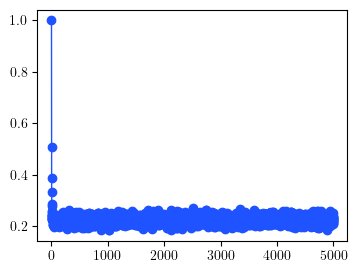

1.0


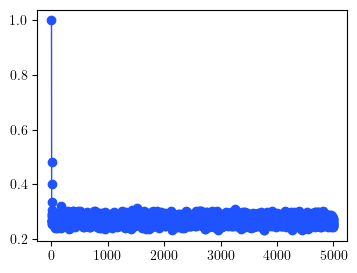

1.0


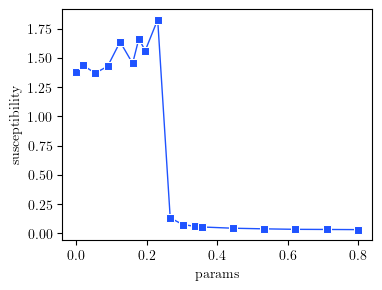

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8, 0.01777777777777778, 0.05333333333333334, 0.08888888888888889, 0.12444444444444444, 0.16, 0.19555555555555557, 0.2311111111111111, 0.26666666666666666, 0.3022222222222222, 0.3377777777777778], 'susceptibility': [1.376336583088192, 1.4374304264132898, 1.6648349206010837, 0.1437046208359453, 0.05434570903226962, 0.043595903133204605, 0.038200990620026666, 0.03410831899728087, 0.03296486531599741, 0.03156941984050803, 1.4388600331226438, 1.3690823246048713, 1.4158164044930042, 1.636452845413985, 1.4519613507006464, 1.5597812858442626, 1.8262822703466621, 0.12093377955848662, 0.07497009683789471, 0.05915996052143915], 'averages': [0.001077, 0.001092, 0.0011782, 0.1440696, 0.289863, 0.348658, 0.3911356, 0.432257, 0.4505856, 0.4849446, 0.001052, 0.0010576, 0.001036, 0.0010934, 0.001117, 0.001

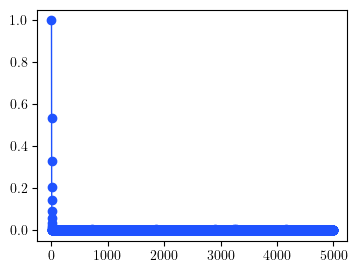

1.0


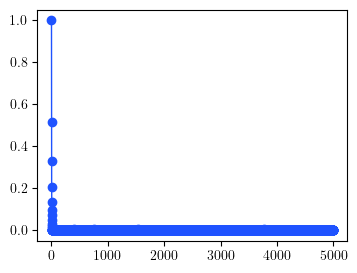

1.0


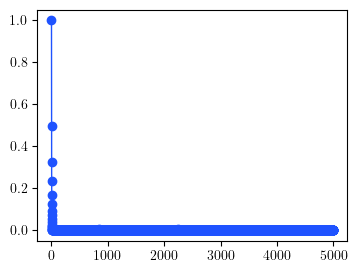

1.0


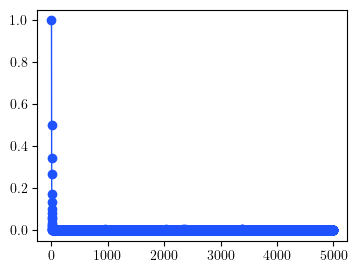

1.0


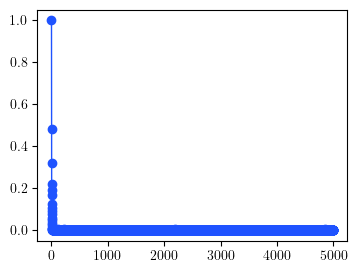

1.0


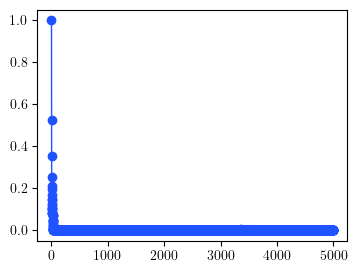

1.0


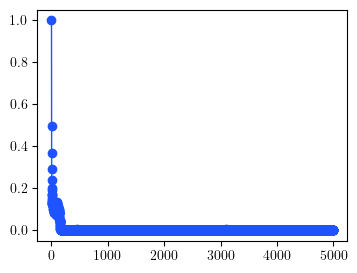

1.0


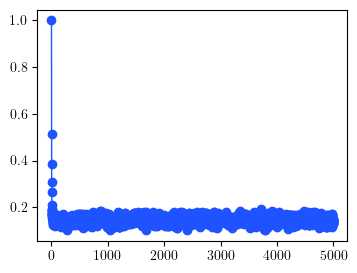

1.0


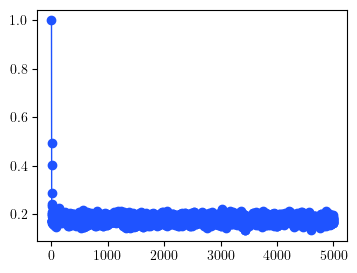

1.0


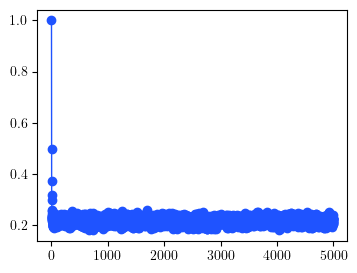

1.0


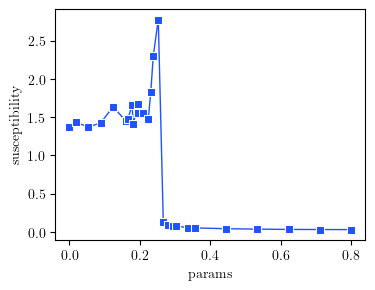

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8, 0.01777777777777778, 0.05333333333333334, 0.08888888888888889, 0.12444444444444444, 0.16, 0.19555555555555557, 0.2311111111111111, 0.26666666666666666, 0.3022222222222222, 0.3377777777777778, 0.1671111111111111, 0.18133333333333332, 0.19555555555555554, 0.20977777777777779, 0.22399999999999998, 0.23822222222222222, 0.25244444444444447, 0.26666666666666666, 0.28088888888888885, 0.2951111111111111], 'susceptibility': [1.376336583088192, 1.4374304264132898, 1.6648349206010837, 0.1437046208359453, 0.05434570903226962, 0.043595903133204605, 0.038200990620026666, 0.03410831899728087, 0.03296486531599741, 0.03156941984050803, 1.4388600331226438, 1.3690823246048713, 1.4158164044930042, 1.636452845413985, 1.4519613507006464, 1.5597812858442626, 1.8262822703466621, 0.12093377955848662, 0.07497009

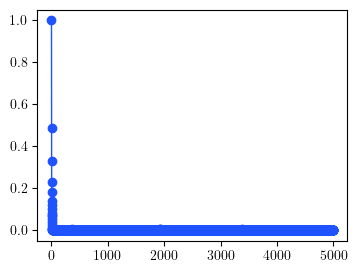

1.0


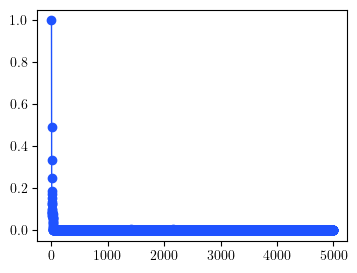

1.0


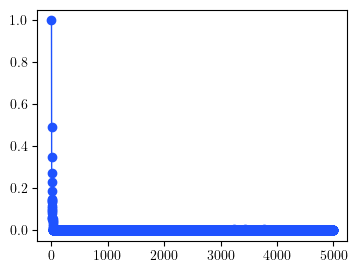

1.0


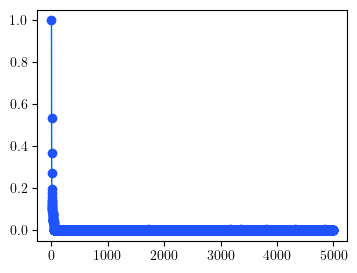

1.0


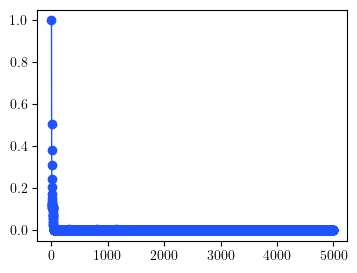

1.0


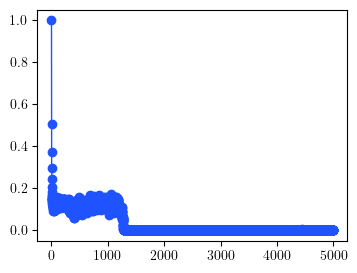

1.0


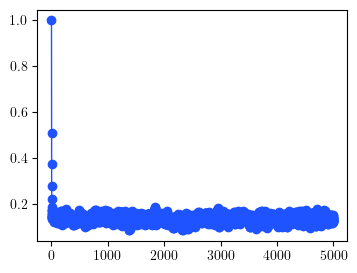

1.0


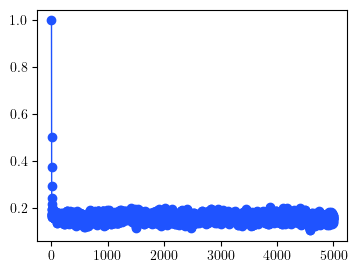

1.0


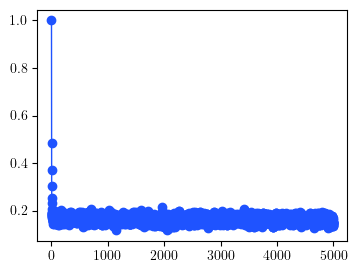

1.0


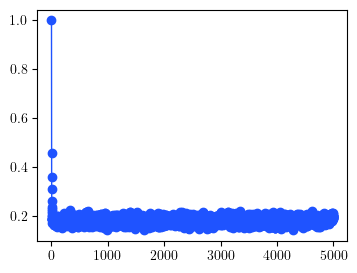

1.0


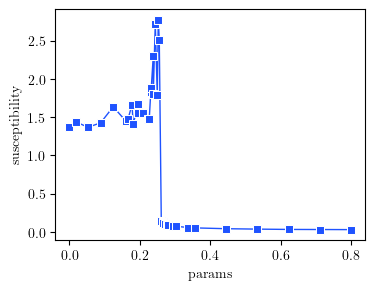

Current history: {'params': [0.0, 0.08888888888888889, 0.17777777777777778, 0.26666666666666666, 0.35555555555555557, 0.4444444444444445, 0.5333333333333333, 0.6222222222222222, 0.7111111111111111, 0.8, 0.01777777777777778, 0.05333333333333334, 0.08888888888888889, 0.12444444444444444, 0.16, 0.19555555555555557, 0.2311111111111111, 0.26666666666666666, 0.3022222222222222, 0.3377777777777778, 0.1671111111111111, 0.18133333333333332, 0.19555555555555554, 0.20977777777777779, 0.22399999999999998, 0.23822222222222222, 0.25244444444444447, 0.26666666666666666, 0.28088888888888885, 0.2951111111111111, 0.22684444444444446, 0.23253333333333334, 0.23822222222222225, 0.24391111111111113, 0.24960000000000002, 0.2552888888888889, 0.2609777777777778, 0.2666666666666667, 0.2723555555555556, 0.2780444444444445], 'susceptibility': [1.376336583088192, 1.4374304264132898, 1.6648349206010837, 0.1437046208359453, 0.05434570903226962, 0.043595903133204605, 0.038200990620026666, 0.03410831899728087, 0.03296

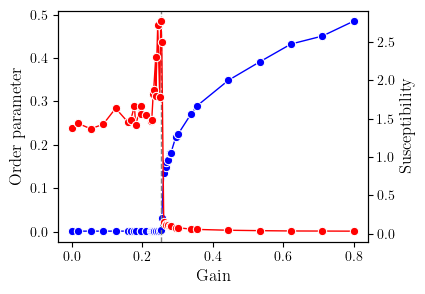

In [169]:
config = midynet.config.ExperimentConfig.reconstruction("susceptiblity", "cowan_backward", "nbinom")

config.prior.size = 1000
config.prior.edge_count = 2500
config.prior.heterogeneity = 1

config.data_model.length = 5000
config.data_model.num_active = 1000
config.data_model.a = 8.
config.data_model.eta = 0.5


histories["cowan_backward"] = searchThresholds(config, "nu", 0, 0.8, delta=2, tol=0.01, numSamples=1, numPoints=10, verbose=1)
plotThresholdSearch(histories["cowan_backward"], f"Gain")



In [11]:
import json

with open("thresholds.json", "w") as f:
    json.dump(histories, f )
    

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.45555556
 0.47777778 0.5        0.52222222 0.54444444 0.54666667 0.55111111
 0.55155556 0.55244444 0.55333333 0.55422222 0.55511111 0.55555556
 0.556      0.55688889 0.55777778 0.55866667 0.55955556 0.56
 0.56444444 0.56666667 0.56888889 0.57333333 0.57777778 0.58222222
 0.58666667 0.58888889 0.61111111 0.63333333 0.65555556 0.66666667
 0.77777778 0.88888889 1.        ]
[0.         0.08333333 0.16666667 0.175      0.19166667 0.20833333
 0.225      0.24166667 0.25       0.25833333 0.26       0.26333333
 0.26666667 0.27       0.27333333 0.275      0.27666667 0.28
 0.28333333 0.28666667 0.29       0.29166667 0.30833333 0.325
 0.33333333 0.41666667 0.5        0.58333333 0.66666667 0.75      ]
[0.82222222 0.91111111 1.         1.08888889 1.10666667 1.14222222
 1.17777778 1.21333333 1.22222222 1.24888889 1.26666667 1.28444444
 1.29155556 1.30577778 1.32       1.32284444 1.32853333 1.33422222
 1.33991111 1.3456     1.34844444 1.3512888

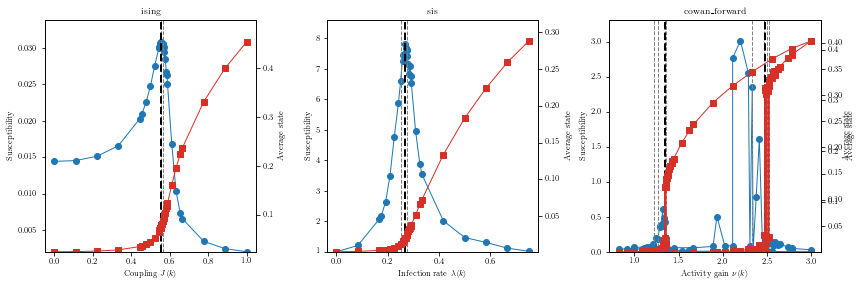

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

xlabels = {
    "ising": r"Coupling $J\langle k \rangle$",
    "sis": r"Infection rate $\lambda \langle k \rangle$",
    "cowan_backward": r"Activity gain $\nu\langle k \rangle$",
    "cowan_forward": r"Activity gain $\nu\langle k \rangle$"
}

for i, k in enumerate(xlabels.keys()):
    if k[:5] == "cowan":
        i = 2
    plotThresholdSearch(ax[i], histories[k], xlabels[k])
    ax[i].set_title(k)
    x = list(histories[k].keys())
#     ax[i].set_xlim([min(x), max(x)])

fig.tight_layout()
plt.show()

In [4]:
res_cowanbackward = {'thresholds': [1.2222222222222223, 1.2666666666666666, 1.3555555555555554, 1.3484444444444443, 1.339911111111111], 'susceptibility': {1.0: [0.059802282845908064, 0.035317890356326626], 1.2222222222222223: [0.07446612568759482], 1.4444444444444444: [0.024341866505123856, 0.024594782032420666], 1.6666666666666665: [0.006991840243193676], 1.8888888888888888: [0.008178240433084315], 2.111111111111111: [0.006356762036091629], 2.333333333333333: [0.005704194169926221], 2.5555555555555554: [0.003952090295917306], 2.7777777777777777: [0.004021597994819511], 3.0: [0.005772468106077235], 0.8222222222222223: [0.042078846417387045], 0.9111111111111112: [0.03728258919376311], 1.088888888888889: [0.033965033624477066], 1.1777777777777778: [0.07183237103587048, 0.0746162122852326], 1.2666666666666666: [0.18526708921782817], 1.3555555555555556: [0.19714253992786024], 1.5333333333333332: [0.015206484320891035], 1.6222222222222222: [0.019772536910977058], 1.1066666666666667: [0.05315274719100304], 1.1422222222222222: [0.06245325297844678], 1.2133333333333334: [0.11548488112435751], 1.2488888888888887: [0.19625866955680793], 1.2844444444444443: [0.3624247096521774], 1.3199999999999998: [0.6303610153862057, 0.5912941187587629], 1.3555555555555554: [0.0], 1.391111111111111: [0.035885605107877354, 0.02203508518179466], 1.4266666666666665: [0.02120751291692739], 1.2915555555555553: [0.3593439841923095], 1.3057777777777775: [0.39872673393841507], 1.334222222222222: [0.4855843633810375, 0.35217742878229075], 1.3484444444444443: [0.11268119245145411], 1.3626666666666665: [0.02601679471627804], 1.3768888888888888: [0.025274465965291523], 1.4053333333333333: [0.026068341269799095], 1.4195555555555555: [0.023371941729762227], 1.3228444444444443: [0.3685277125256362], 1.3285333333333331: [0.48735749127629335], 1.339911111111111: [0.42871372030618354], 1.3456: [0.16669886639640458], 1.3512888888888888: [0.15647573410939486], 1.3569777777777776: [0.048694997898105725], 1.3626666666666667: [0.04832161980492115], 1.3683555555555555: [0.04058393298443019], 1.3740444444444444: [0.029966079307858252]}, 'averages': {1.0: [0.002291333333333333, 0.002275], 1.2222222222222223: [0.003843916666666667], 1.4444444444444444: [0.18628183333333334, 0.18441633333333332], 1.6666666666666665: [0.25260325000000006], 1.8888888888888888: [0.29566924999999994], 2.111111111111111: [0.32880558333333326], 2.333333333333333: [0.3563439166666667], 2.5555555555555554: [0.381438], 2.7777777777777777: [0.40207583333333335], 3.0: [0.41712108333333325], 0.8222222222222223: [0.0019098333333333335], 0.9111111111111112: [0.0020538333333333333], 1.088888888888889: [0.002592083333333334], 1.1777777777777778: [0.0031264166666666662, 0.003235166666666667], 1.2666666666666666: [0.0047859166666666675], 1.3555555555555556: [0.12846583333333333], 1.5333333333333332: [0.215896], 1.6222222222222222: [0.24068749999999997], 1.1066666666666667: [0.0026795], 1.1422222222222222: [0.0029079999999999996], 1.2133333333333334: [0.003761583333333334], 1.2488888888888887: [0.0046672499999999995], 1.2844444444444443: [0.006381249999999999], 1.3199999999999998: [0.018064090909090908, 0.013243555555555557], 1.3555555555555554: [0.017717], 1.391111111111111: [0.16331933333333334, 0.1645291666666667], 1.4266666666666665: [0.1804663333333333], 1.2915555555555553: [0.006817083333333334], 1.3057777777777775: [0.008361249999999999], 1.334222222222222: [0.018065499999999998, 0.028147], 1.3484444444444443: [0.010969], 1.3626666666666665: [0.14774358333333334], 1.3768888888888888: [0.15753541666666668], 1.4053333333333333: [0.17017683333333333], 1.4195555555555555: [0.17574275000000003], 1.3228444444444443: [0.015570857142857141], 1.3285333333333331: [0.0247544], 1.339911111111111: [0.028988333333333335], 1.3456: [0.13029208333333334], 1.3512888888888888: [0.1336335], 1.3569777777777776: [0.14529316666666667], 1.3626666666666667: [0.14822266666666667], 1.3683555555555555: [0.15155266666666667], 1.3740444444444444: [0.15390475]}}
res_cowanforward = {'thresholds': [2.333333333333333, 2.4666666666666663, 2.5199999999999996, 2.4986666666666664, 2.4787555555555554], 'susceptibility': {1.0: [0.06582342816486178], 1.2222222222222223: [0.05846771554222465], 1.4444444444444444: [0.05886050084499977], 1.6666666666666665: [0.05636077201783856], 1.8888888888888888: [0.07597854964203571], 2.111111111111111: [2.767012986132994], 2.333333333333333: [2.3482120646154567], 2.5555555555555554: [0.13273392178391602, 0.1429868375465543, 0.12636162902245188, 0.13562615249096274], 2.7777777777777777: [0.048273284245777835], 3.0: [0.02796399647246088], 1.9333333333333331: [0.5019707355715289], 2.022222222222222: [0.08430412987908625], 2.1111111111111107: [0.08605426655118496], 2.1999999999999997: [3.01031197023769], 2.2888888888888888: [2.551484730488011], 2.3777777777777773: [1.4936778340737853, 0.05725836179260399], 2.4666666666666663: [0.0], 2.644444444444444: [0.11634734159765853], 2.733333333333333: [0.06366306586357612], 2.306666666666666: [0.08483145251179022], 2.342222222222222: [0.02203645118532276], 2.413333333333333: [1.612603904653256], 2.4488888888888884: [0.07574931880108993], 2.4844444444444442: [0.0, 0.0], 2.5199999999999996: [0.0], 2.591111111111111: [0.14152503814311138], 2.6266666666666665: [0.09697114435559699], 2.4559999999999995: [0.0], 2.4702222222222217: [0.0], 2.484444444444444: [0.1862039233625933], 2.4986666666666664: [0.0], 2.5128888888888885: [0.17601272646544827, 0.2056244358043804], 2.5271111111111106: [0.12009717154901707], 2.5413333333333328: [0.11971153547533313], 2.5697777777777775: [0.10336384516048905], 2.5839999999999996: [0.10116791146914346], 2.4730666666666665: [0.17262946885833116], 2.4787555555555554: [0.1632815252244113], 2.490133333333333: [0.1967107332257652], 2.495822222222222: [0.17006489445103817], 2.501511111111111: [0.16551573026034638], 2.5071999999999997: [0.18810745863537096], 2.5185777777777774: [0.16745088342200443], 2.524266666666666: [0.165636174252894]}, 'averages': {1.0: [0.0006681041666666667], 1.2222222222222223: [0.0006765416666666668], 1.4444444444444444: [0.0006866458333333334], 1.6666666666666665: [0.0007036041666666666], 1.8888888888888888: [0.0007289347826086956], 2.111111111111111: [0.003951926829268293], 2.333333333333333: [0.0051069999999999996], 2.5555555555555554: [0.32785991666666664, 0.3289685, 0.3345871458333334, 0.33590816666666673], 2.7777777777777777: [0.37676012499999995], 3.0: [0.4032305833333332], 1.9333333333333331: [0.0008020851063829787], 2.022222222222222: [0.0007639555555555556], 2.1111111111111107: [0.0007817142857142856], 2.1999999999999997: [0.0029791290322580648], 2.2888888888888888: [0.005074166666666667], 2.3777777777777773: [0.0057475, 0.0009460000000000001], 2.4666666666666663: [0.031686], 2.644444444444444: [0.3537766666666667], 2.733333333333333: [0.3699881666666666], 2.306666666666666: [0.0008985], 2.342222222222222: [0.000871], 2.413333333333333: [0.012905], 2.4488888888888884: [0.0009175], 2.4844444444444442: [0.006315, 0.028485], 2.5199999999999996: [0.028905], 2.591111111111111: [0.33762481250000004], 2.6266666666666665: [0.3492641458333334], 2.4559999999999995: [0.006016], 2.4702222222222217: [0.006147], 2.484444444444444: [0.3013465], 2.4986666666666664: [0.000904], 2.5128888888888885: [0.3099441666666667, 0.30629618750000004], 2.5271111111111106: [0.3284067708333333], 2.5413333333333328: [0.3333821458333333], 2.5697777777777775: [0.3434210208333333], 2.5839999999999996: [0.3463678333333333], 2.4730666666666665: [0.31004310416666664], 2.4787555555555554: [0.3122855625], 2.490133333333333: [0.30353102083333333], 2.495822222222222: [0.31139870833333333], 2.501511111111111: [0.314690125], 2.5071999999999997: [0.3115742083333333], 2.5185777777777774: [0.3202021875], 2.524266666666666: [0.3179698125]}}

In [8]:
import json
res = [
    res_sis,
    res_glauber,
    res_cowanbackward,
    res_cowanforward,
]
labels = ["sis", "glauber", "cowan-backward", "cowan-forward"]
for r, l in zip(res, labels):
    with open(f"threshold-{l}.json", "w") as f:
        json.dump(r, f)

In [120]:
nu = np.linspace(0.1, 0.8, 20)

config.data_model.length = 1000
config.data_model.mu = 1.
config.data_model.a = 8.

data = defaultdict(list)
for i, _nu in enumerate(tqdm.tqdm(nu)):
    data["nu"].append(_nu)
    config.data_model.nu = _nu
    priormodel = midynet.config.GraphFactory.build(config.prior)
    for ii, mode in zip([1, 1000], ["fw", "bw"]):
        datamodel = midynet.config.DataModelFactory.build(config.data_model)
        datamodel.set_graph_prior(priormodel)
        datamodel.sample(ii)
        x = np.array(datamodel.get_past_states())
        data[f"average_{mode}"].append(x.mean())
sns.lineplot(pd.DataFrame(data), x="nu", y="average_fw")
sns.lineplot(pd.DataFrame(data), x="nu", y="average_bw")

  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: Could not interpret value `average` for parameter `y`

<AxesSubplot: xlabel='nu', ylabel='average_fw'>

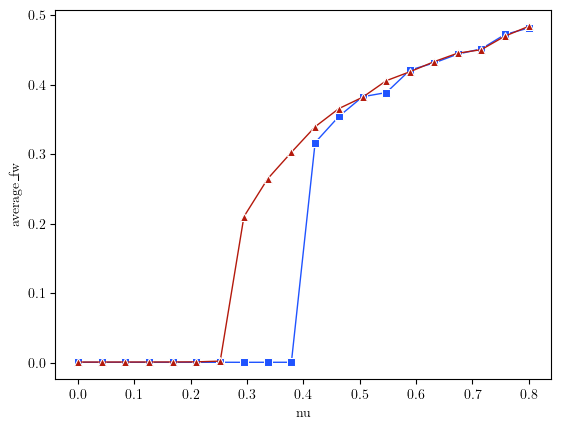

In [121]:
sns.lineplot(pd.DataFrame(data), x="nu", y="average_fw")
sns.lineplot(pd.DataFrame(data), x="nu", y="average_bw")

In [129]:
datamodel.sample(1000)

In [131]:
np.array(datamodel.get_past_states())

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [1, 0, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 1, 1]])